# Tutorial 0: Basic Data Structure `data_neuro`

2017-0928, Shaobo Guan, Brown University

This short notebook demonstrates the core data strucure used in this module: **data_neuro**, which conviniently stores the multi-channel neurophysiological data (either for spikes or LFPs) alignted to a task-related event onset (e.g. trail onset, stimulus onset, response onset. etc )

Most data analsis and visialization methods package `PyNeuroSG` works on this data stucure.   

# Section 0: Get Example Data

example data can be downloaded from dropbox public link: 'https://www.dropbox.com/s/ujr8qgcgkqp9lgr/example_data_Thor_180530.zip?dl=1', decompress it and put under package_root/deme_data

The script below will process this automatically. If the script below does not work (perhaps due to Drobbox API), you and downloa and decompress manually

In [1]:
import os
import urllib.request
import zipfile

cur_path = os.getcwd()

rel_path_demo_data_folder = '../demo_data'
filename_zip_demo_data = 'example_data_Thor_180530.zip'
dirname_demo_data = 'example_data_Thor_180530'
data_url = 'https://www.dropbox.com/s/ujr8qgcgkqp9lgr/example_data_Thor_180530.zip?dl=1'

rel_path_demo_data_folder

path_demo_data_folder = os.path.normpath(os.path.join(cur_path, rel_path_demo_data_folder))
path_zip_demo_data = os.path.join(path_demo_data_folder, filename_zip_demo_data)
path_dir_demo_data = os.path.join(path_demo_data_folder, dirname_demo_data)

# create demo_data_folder
if not os.path.isdir(path_demo_data_folder):
    os.mkdir(path_demo_data_folder)
    print('create dir at {}'.format(path_demo_data_folder))

# download demo data from dropbox url 
if not os.path.exists(path_zip_demo_data):
    with urllib.request.urlopen(data_url) as u:
        print('reading url ...')
        url_content = u.read()
    with open(path_zip_demo_data, 'wb') as f:
        print('creating zip file ...')
        f.write(url_content)

# decompress zip file
if not os.path.exists(path_dir_demo_data):
    with zipfile.ZipFile(path_zip_demo_data, 'r') as zip_ref:
        zip_ref.extractall(rel_path_demo_data_folder)
    
print('finished')

finished


Now the example data should exist in the following structure:
```
package root
 |- demo_data (directory)
      |- example_data_Thor_180530 (directory)
         |-Thor_U16_180530 (direcotry containing neurophysiological data recorded using TDT device)
         |    |- h_srv_mask_053018002  (directory for a recording session, defined by TDT recording device)
         |    |- h_srv_mask_053018003
         |    |- h_V4_spot_053018010
         |
         |-behavioral data (directory containing behavioral data)
              |- h_srv_mask_053018002.dg  (file for a recording session, a big table)
              |- h_srv_mask_053018003.dg
              |- h_V4_spot_0530180010.dg
```

# Section 1: Read neural data usign python-neo package

## 1.1 load neural andbehaviral data

In [2]:
path_dir_demo_data

'/shared/homes/sguan/Coding_Projects/PyNeuroSG/demo_data/example_data_Thor_180530'

In [3]:
# standard Python pakages
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd         # pandas tabular DataFrame for task/behavioral data
import matplotlib as mpl    # plot
import matplotlib.pyplot as plt
import re                   # regular expression
import time                 # time code execution
import pickle

# sub-modules in the package of PyNeuroSG 
import signal_align         # in this package: align neural data according to task
import df_ana               # in this package: functions related to analys DataFrame (table-like) data
import PyNeuroAna as pna    # in this package: analysis
import PyNeuroPlot as pnp   # in this package: plot
import misc_tools           # in this package: misc

import data_load_DLSH       # package specific for data stored in Sheinberg lab

# make matplotlib plots show in Jupyter Notebook
%matplotlib inline

/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
""" load data """
keyword_tank = 'Thor_U16.*'     # regular expression, or use the full name 'Thor_U16_180530'
keyword_block = 'h_srv_.*'      # regular expression of the recording session names
tf_interactive = False          # if True, select recording sessions manually, otherwise, use all that matches

""" load neural data and behaviral data that matches the keywords """
[blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data(keyword = keyword_block, keyword_tank=keyword_tank,
                                                           tf_interactive=tf_interactive,
                                                           dir_tdt_tank=path_dir_demo_data,
                                                           dir_dg=os.path.join(path_dir_demo_data, 'behavioral_data'),
                                                          mode='both')

filename_common = misc_tools.str_common(name_tdt_blocks)
dir_temp_fig = './temp_figs'

""" make sure data field exists and standardize it """
data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
blk = data_load_DLSH.standardize_blk(blk)

the following tdt blockes are selected: ['h_srv_mask_053018002', 'h_srv_mask_053018003']
the following dg files are selected: ['h_srv_mask_053018002', 'h_srv_mask_053018003']
the their intersections are: ['h_srv_mask_053018002', 'h_srv_mask_053018003']

the data files to be loaded are: ['h_srv_mask_053018002', 'h_srv_mask_053018003']
loading TDT block: h_srv_mask_053018002
loading TDT block: h_srv_mask_053018003
finish loading tdt blocks
loading dg: h_srv_mask_053018002.dg
loading dg: h_srv_mask_053018003.dg
finish loading and concatenating dgs


Now the neural data and behaviroal data hava been loaded.

The neural data is stored in blk, and the behaviral data is stroed in data_df

## 1.2 the stuture of the raw neural data: blk:

blk is the block object defined in the python-neo module:

htts://neuralensemble.org/neo/

>  Neo is a package for representing electrophysiology data in Python, together with support for reading a wide range of neurophysiology file formats including
Spike2, NeuroExplorer, AlphaOmega, Axon, Blackrock, Plexon, Tdt.

We here use the neo package to read the neural data recorded from differnt equipments into a standard format, therefore the later analysis is independet of the ogirinal data format, making our analysis pakage platform-indepdent

The neo block object **blk** contains multiple segments, each corresponding to a recorded data file, e.g. a experiment session.  Every segments contains several types of data, e.g. spiketrains (time stamps), anglogsignals (e.g. continuouly sampled LFP signal) and events (e.g., timing information of the start and end of a trial), as is shown below



In [6]:
blk.segments[0].spiketrains[0]

<SpikeTrain(array([   3.35949922,    3.40254807,    3.53701973, ..., 1143.4421463 ,
       1143.6031599 , 1143.73562455]) * s, [0.0 s, 1144.1150946617126 s])>

In [7]:
blk.segments[0].analogsignals[0]

AnalogSignal with 1 channels of length 1163648; units V; datatype float32 
name: 'LFPs 1'
annotations: {'channel_index': 1}
sampling rate: 1017.2526245117188
time: 9.5367431640625e-07 to 1143.9125079954242

In [8]:
print(blk.segments[0].events[0])

[4.19616699e-05 1.00003934e+00 2.00003672e+00 ... 1.14199712e+03
 1.14299712e+03 1.14399711e+03] s


# Section 2 structure of the behavioral data:

Other than the neural data, we ususally keep tracks of the task (e.g. the identity and onset time of a visual stimulus) and animals behaviral response (the correctness and timing of lever press and eye movement)

The behviral data may be lab-specific, but typically organized as a table-like structure where every row represetn one trial and over column represent one feature of the task (stimulus onse, object identity, correct/wrong response, etc.)

In [9]:
print('Here are all the column names of the example table data_df:')
print(data_df.columns.tolist())

print("Here are several example columns of the first 10 rows of the table")
data_df[['obsid', 'stimon', 'stim_names', 'stim_familiarized', 'mask_opacity']].head(10)

Here are all the column names of the example table data_df:
['blinkstarts', 'blinkstops', 'datecode', 'day', 'edge_blur', 'ems', 'endobs', 'endtrial', 'eyedist', 'file', 'fileid', 'fixjump', 'fixjump_pos', 'fixoff', 'fixon', 'grayscale', 'ids', 'mask_extensions', 'mask_index', 'mask_linearity', 'mask_names', 'mask_opacity', 'mask_orientation', 'mask_paths', 'mask_scale', 'month', 'nsaccades', 'obsid', 'order', 'reward_times', 'sacamps', 'sacdirs', 'sacfroms', 'sacstops', 'sactimes', 'sactos', 'sacvels', 'stim_categories', 'stim_durations', 'stim_extensions', 'stim_familiarized', 'stim_names', 'stim_paths', 'stim_posttimes', 'stim_rotations', 'stim_scales', 'stim_types', 'stimoff', 'stimon', 'stimtype', 'subj', 'targecc', 'year', 'filename', 'fileindex', '', 'obs_total', 'mask_opacity_int', 'stim_sname']
Here are several example columns of the first 10 rows of the table


,obsid,stimon,stim_names,stim_familiarized,mask_opacity
0,1,634,face_n09618957_11575,0,0.9
1,1,1065,dog_n02084071_85,0,0.0
2,1,1495,face_n09618957_3520,0,0.7
3,1,1925,bird_n01503061_4201,1,0.9
4,1,2356,face_n09618957_5192,1,0.0
5,10,524,house_n03545150_17794,1,0.9
6,10,954,face_n09618957_5192,1,0.9
7,10,1384,house_n03545150_8911,1,0.7
8,10,1815,house_n03545150_17794,1,0.7
9,10,2245,dog_n02084071_85,0,0.0


# Section 3: `data_neuro`: neural response aligned to the task

the structure `data_neuro` aligns the raw neural data `blk` to the trial structure defined by the behaviral data `data_df`

We usually align neuronal response to some important timestamps (eg. visual stimulus onset, motor command execusion, etc) and study the neuronal activity in respond to different exprimental conditions.  To do that efficiently, we organized data into the structure: `data_neuro`

## 3.1 create `data_neuro` by aligning neural data to event

In [11]:
""" align neural data to the event 'stimon' from behaviral data """

# get the timestamps of the stimon event relative to the sync signal, and translate it to the absolute time in the neural data file
ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon')

# align the neural data according to the timestamps, here only use the spiketrains data
data_neuro = signal_align.blk_align_to_evt(blk, ts_StimOn, [-0.100, 0.600], type_filter='spiketrains.*',
                                           name_filter='.*Code[1-9]$', spike_bin_rate=1000)
signal_align.include_trial_info(data_neuro, data_df)

{'data': array([[[   0.,    0.,    0., ...,    0.,    0., 1000.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,

## 3.2 structure of `data_neuro`

In [12]:
print('the dictionary data_neural contains the following fields:    {}'.format(data_neuro.keys()))

print('the "data" field contains a 3D numpy array of shape  {}'.format(data_neuro['data'].shape) )

print('the "ts" field contains a 1D numpy array of length {}'.format(data_neuro['ts'].shape) )

print('the "signal_info" field contains a table of length {}'.format(data_neuro['signal_info'].shape) )

print('the behaviral data table data_df contains {} rows'.format(len(data_df)))

the dictionary data_neural contains the following fields:    dict_keys(['data', 'ts', 'signal_info', 'trial_info'])
the "data" field contains a 3D numpy array of shape  (1200, 700, 12)
the "ts" field contains a 1D numpy array of length (700,)
the "signal_info" field contains a table of length (12,)
the behaviral data table data_df contains 1200 rows


`data_neuro['data']` contains the aligned neural data.

The shape of it is [num_trials, num_timesstampts, num_signals], where every entry represent (the number_of_spikes * spike_bin_rate) during a time bin of a trail from a signal

The example data contains:

- 1200 trials, whose the task/behaviroral info is stored at table `data_df`
- 700 timestamps (sampled at 1000 Hz, which is specified when calling funciton `blk_align_to_evt(spike_bin_rate=1000)`), the timing of every timestamp relative to the aligning event onset is strored in `data_neuro['ts']`; here the aligning event is `'stimon'`
- 12 signals, here every signal is either MUA or SUA, whose names are shown below (show the first 5 rows): 

In [13]:
data_neuro['data'][0:10, 190:195, 0]

array([[   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0., 1000.,    0.],
       [   0.,    0., 1000.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0., 1000.,    0.],
       [   0.,    0.,    0.,    0., 1000.]])

In [14]:
data_neuro['signal_info'][0:5]

array([('Chan5 Code1', 'spiketrains', 1000., 5, 1),
       ('Chan6 Code2', 'spiketrains', 1000., 6, 2),
       ('Chan7 Code2', 'spiketrains', 1000., 7, 2),
       ('Chan8 Code2', 'spiketrains', 1000., 8, 2),
       ('Chan9 Code1', 'spiketrains', 1000., 9, 1)],
      dtype=[('name', '<U32'), ('type', '<U32'), ('sampling_rate', '<f8'), ('channel_index', '<i8'), ('sort_code', '<i8')])

We can easily get a rough overview of the data by plotting it usign funciton `DataNeuroSummaryPlot()`

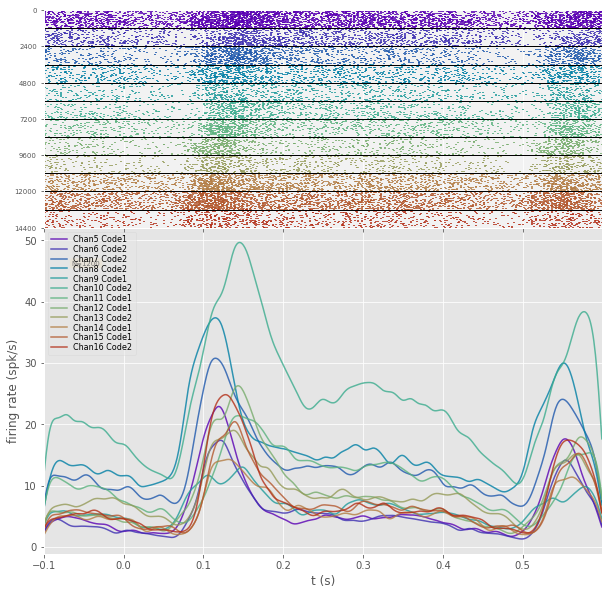

In [15]:
plt.figure(figsize=(10,10))
pnp.DataNeuroSummaryPlot(data_neuro, tf_legend=True)

In this figure, the rasters and PSTH across all trials and all singals are shown relative to the aligning evetn onset (`'stimon'` in this example).  Every trance represents a signal with their names listed in the legend, `averaged across N=1200` trials

# 4 Group data by task/behaviroal conditions

We usually want to group the data according to the conditions that we care about, e.g. differnt visual stimulus, correct/wrong response, etc.

In whis example dataset, I only want to get the trials where 'mask_opacity' equals zero, and then group data by `'stim_sname'`

In [16]:
data_neuro = signal_align.neuro_sort(data_df, grpby=['stim_sname'], fltr=data_df['mask_opacity']==0.0, neuro=data_neuro)

In [17]:
print('Now data_neuron contains the following fields:\n{}\n'.format(list(data_neuro.keys())))

print('field fltr')
print(data_neuro['fltr'])
print('')
print('field grpby')
print(data_neuro['grpby'])
print('')
print('field cdtn')
print(data_neuro['cdtn'])
print('')
print('field cdtn_indx of one condition: bird_fam_166')
print(data_neuro['cdtn_indx']['bird_fam_166'])
print('')

Now data_neuron contains the following fields:
['data', 'ts', 'signal_info', 'trial_info', 'grpby', 'fltr', 'cdtn', 'cdtn_indx']

field fltr
[False  True False ... False  True  True]

field grpby
['stim_sname']

field cdtn
['bird_fam_166', 'bird_fam_4201', 'bird_nov_21245', 'bird_nov_7473', 'car_fam_3160', 'car_fam_8642', 'car_nov_13043', 'car_nov_5021', 'dog_fam_1682', 'dog_fam_377', 'dog_nov_14126', 'dog_nov_85', 'face_fam_5192', 'face_fam_7156', 'face_nov_11575', 'face_nov_3520', 'house_fam_17794', 'house_fam_8911', 'house_nov_5871', 'house_nov_7301']

field cdtn_indx of one condition: bird_fam_166
[  96  106  123  152  182  382  415  503  562  595  707  745  795  812
  903  972  989 1007 1057 1150]



We now see that there are several fields added to the dictionary 'data_neuro'

Note that the filter and group-by action **does not** acturally modify the actrual data, but only adds the field `'cdtn_indx'` that stores the index of the trials falliing into that condition.

In this example, we first filter the trail by setting `fltr=data_df['mask_opacity']==0.0`, therefore only trials satisfying this constain can be listed in the `cdtn_indx`; we also group trials by the field `'stim_snames'` of table `data_df`, and therefore trials from each unique condition of `'stim_sname'` will be listed in `'cdtn_indx'`

## 4.1 Manually select one condition

We now can get the spiking data from trials where `data_df['mask_opacity']==0.0` and `data_df['stim_sname']=='bird_fam_10012'` as follows


In [18]:
index_of_interest = data_neuro['cdtn_indx']['house_fam_17794']
data_of_interest = data_neuro['data'][index_of_interest, :, :]
data_of_interest.shape

(20, 700, 12)

We can tell there are 20 trials that falls in our selection (still 700 timestamps and 12 channels)

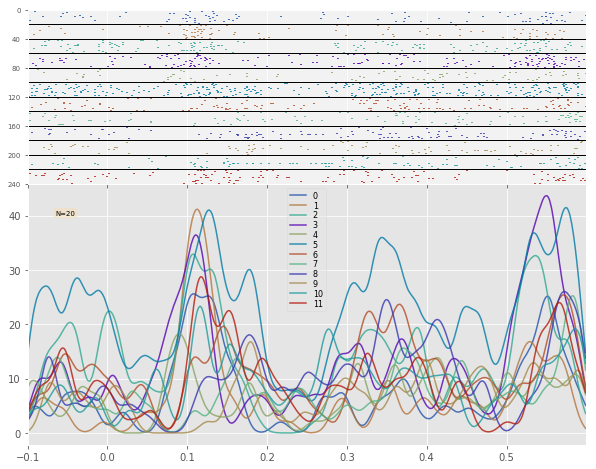

In [19]:
plt.figure(figsize=(10,8))
pnp.PsthPlot(data_of_interest, ts = data_neuro['ts'], sk_std=0.01, tf_legend=True)

## 4.2 Compare one neuron's activity across conditions

### 4.2.1 in one plot

To understand one neurons's function, we are ussually interested in how its response gets modulatd by experimental conditions, instead of averating it over all conditions.

Here we can conviniently compare the response across conditions by specifying argument `cdtn` (condition) to the plot function `PsthPlot`.  By doing this, the trials of the same condition are grouped together

The upper panel is a raster plot of the spiking activity (different conditions are sorted and indicated by color), and the lower panel is the average spiking traces coreesponing to the four condtions.

Text(0.5,1,'Chan10 Code2')

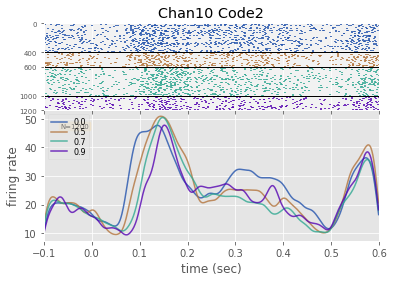

In [20]:
index_signal = 5
pnp.PsthPlot(data_neuro['data'][:,:,index_signal], ts=data_neuro['ts'], 
             cdtn=data_df['mask_opacity'], sk_std=0.01, tf_legend=True, 
             xlabel='time (sec)', ylabel='firing rate')
plt.title(data_neuro['signal_info']['name'][index_signal])

### 4.3.2 in many subplots 


sometimes there are multiple dimentions to compare and one single panel is not sufficient.  Now we can plot the response in multiple subplots


Text(0.5,0.98,"subplots grouped by ['stim_familiarized', 'mask_opacity_int']")

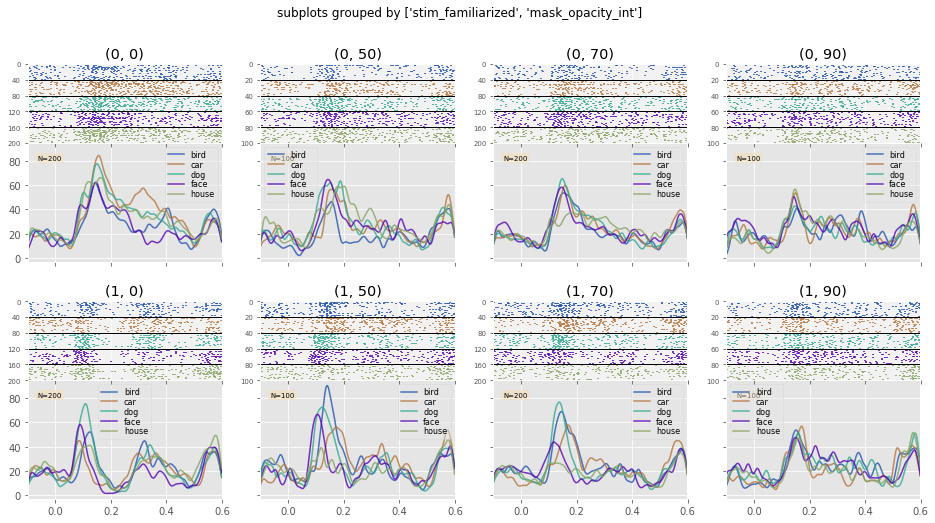

In [21]:
sbuplot_groupby = ['stim_familiarized', 'mask_opacity_int']
df_grpby = df_ana.DfGroupby(data_df, groupby=sbuplot_groupby, tf_aggregate=False)
h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_grpby['order'], figsize=(16,8))
for cdtn in df_grpby['idx']:
    plt.axes(h_axes[cdtn])
    idx_trials = df_grpby['idx'][cdtn]
    pnp.PsthPlot(data_neuro['data'][idx_trials, :, index_signal], ts=data_neuro['ts'], 
                 cdtn=data_df['stim_categories'][idx_trials], sk_std=0.01, tf_legend=True)
    plt.title(cdtn)
plt.suptitle('subplots grouped by {}'.format(sbuplot_groupby))

# 4.3.3 a master function 

To sort conditions and plot neural data conviniently, there is a convinient wrapper function PsthPlotMultiPanel

(<matplotlib.figure.Figure at 0x7f6e9ce39470>,
 {(0, 0): <matplotlib.axes._subplots.AxesSubplot at 0x7f6e9cbab2e8>,
  (0, 50): <matplotlib.axes._subplots.AxesSubplot at 0x7f6e9d1b2588>,
  (1, 0): <matplotlib.axes._subplots.AxesSubplot at 0x7f6e9d5143c8>,
  (1, 50): <matplotlib.axes._subplots.AxesSubplot at 0x7f6e9d65c358>})

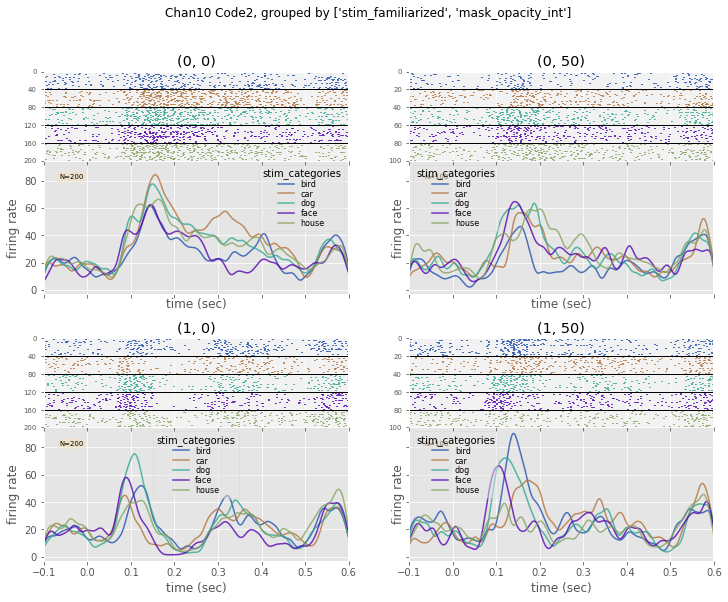

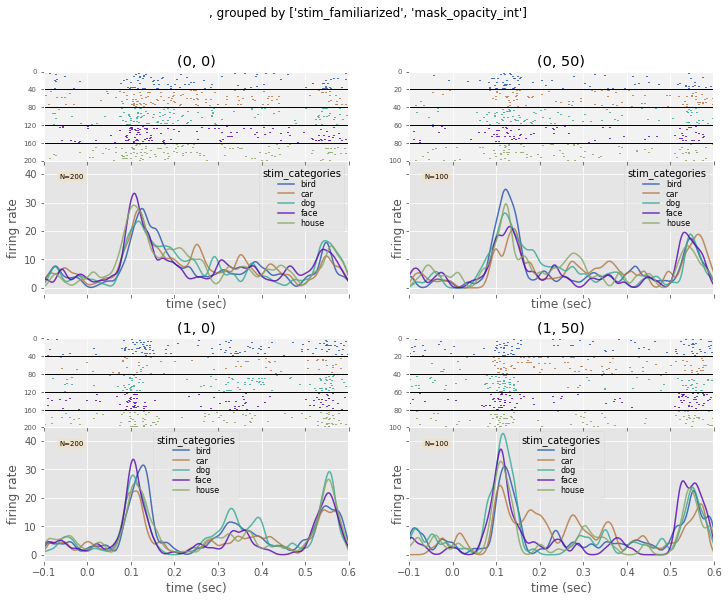

In [23]:
# usse data_neuro
pnp.PsthPlotMultiPanel(data_neuro=data_neuro, index_signal=5, limit=data_df['mask_opacity']<0.6,
                      groupby_subplots=['stim_familiarized', 'mask_opacity_int'], groupby_panel='stim_categories', 
                       tf_legend=True, sk_std=0.01, xlabel='time (sec)', ylabel='firing rate')

# some result, more controls
pnp.PsthPlotMultiPanel(data2D=data_neuro['data'][:,:,0], ts=data_neuro['ts'], data_df=data_df, limit=data_df['mask_opacity']<0.6,
                      groupby_subplots=['stim_familiarized', 'mask_opacity_int'], groupby_panel='stim_categories', 
                       tf_legend=True, sk_std=0.01, xlabel='time (sec)', ylabel='firing rate')

